In [126]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Building a Robot Simulator in 3D with Translational Dynamics

In [42]:
# Perfect sensor
def sense(x):
    return x

### Simluation and dynamics
To understand the dynamics of the system, we need to describe how the state is changing with respect to time. In other words, analyzing the derivative of the state vector $\dot{\boldsymbol{x}}=[\dot{\boldsymbol{p}}, \ddot{\boldsymbol{p}}]^\top$.
Assuming no air drag or external factors, the system does not have influence over the velocity $\dot{\boldsymbol{p}}$, but the acceleration will depend on the control input and the gravity. Following the Newton dynamics,
$$
\boldsymbol{u}  - m\, g  \hat{\boldsymbol{z}} = m \ddot{\boldsymbol{p}},
$$
and divide it by the mass. Then, we can write the derivative of the extended state vector as
$$
	\begin{equation}	
		\dot{\boldsymbol{x}} =
		\begin{bmatrix}
			\dot{\boldsymbol{p}}
			\\ 
			\frac{\boldsymbol{u}}{m} - g \hat{\boldsymbol{z}} 
		\end{bmatrix}
	\end{equation}.
	$$

In this simulation, we take into account the collision with the floor. We assume that the collision is plastic, meaning that all the kinetic energy, related to the velocity, is absorbed by the impact.

### Blank Controller for Free fall

In [ ]:
def control_blank(t, y):    
    ux = 0
    uy = 0
    uz = 0 
    return [ux, uy, uz]

### Normal Simulator

In [180]:
def simulate(Δt, x, u, m=1, g=9.8):
    # Control input affects the acceleration
    dx = array([x[3], x[4], x[5], u[0]/m, u[1]/m, u[2]/m])
    
    # Buoyancy force
    fb = 9.0
    
    # Include the gravity in the acceleration in z
    dx[5] = - g
        
    # Euler integration
    x += Δt * dx
    
    
    # Simulate the floor (Plastic collision)    
    if x[2] < 0:        
        x[2] = 0  # z = 0
        x[5] = 0  # vz = 0
    
    return x

### Buoyancy Simulator

In [177]:
def simulate_buoyancy(Δt, x, u, m=1, g=9.8):
    # Control input affects the acceleration
    dx = array([x[3], x[4], x[5], u[0]/m, u[1]/m, u[2]/m])
    
    # Buoyancy force
    fb = 9.0
    
    # Include the gravity in the acceleration in z
    dx[5] += - g
    dx[5] += fb / m
        
    # Euler integration
    x += Δt * dx
    
    # Simulate the floor (Plastic collision)    
    if x[2] < 0:        
        x[2] = 0  # z = 0
        x[5] = 0  # vz = 0
    
    return x

### PD Controller

In [174]:
def control_PD(t, y):   
    # Desired altitude
    zd = 15
    
    # Constants (g, m)
    g = 9.8
    
    # Proportional and derivative gains
    kp = 1.
    kd = 1.
    kv = 0.01
    
    # Extract current state variables
    x, y, z, vx, vy, vz = y
    
    # Calculate errors
    z_error = zd - z
    vz_error = 0 - vz  
    
    # Compute control signals
    ux = 0  
    uy = 0  
    uz = (kp * z_error) + (kd * vz_error) + g
    
    return [ux, uy, uz]

In [182]:
tf = 3.
Δt = 0.1    # Time step
time = linspace(0.,tf, int(tf / Δt) + 1)  # Time interval


# Initial conditions
x = array([0., 0., 10., 0.,0.,0.])
x_log = [copy(x)]
inte = 0
for t in time:    
    y = sense(x)
    u = control_PD(t, y)
    x = simulate(Δt, x, u)
    x_log.append(copy(x))
    
x_log = array(x_log)

### PID Controller

In [147]:
def control_PID(t, y, inte):   
    # Desired altitude
    zd = 15
    
    # Constants (g, m)
    g = 9.8
    
    # Assuming mass of the system is 1 kg
    m = 1
    real_m = 0.8
    
    # Proportional and derivative gains
    kp = 1.
    kd = 1.
    kv = 0.1
    ki = 0.01
    
    # Extract current state variables
    x, y, z, vx, vy, vz = y
    
    # Calculate errors
    z_error = zd - z
    
    # Desired vertical velocity is 0
    vz_error = 0 - vz  

    # Integral term
    inte += z_error
    
    # Compute control signals
    ux = 0 
    uy = 0  
    
    uz = (kp * z_error) + (kd * vz_error) + (g*m) + inte*ki
    
    return [ux, uy, uz]

In [176]:
tf = 3.
Δt = 0.1    # Time step
time = linspace(0.,tf, int(tf / Δt) + 1)  # Time interval


# Initial conditions
x = array([0., 0., 10., 0.,0.,0.])
x_log = [copy(x)]
inte = 0
for t in time:    
    y = sense(x)
    u = control_PID(t, y, inte)
    x = simulate(Δt, x, u)
    x_log.append(copy(x))
    
x_log = array(x_log)

# Results
We can start analyzing how the height changes with respect to time

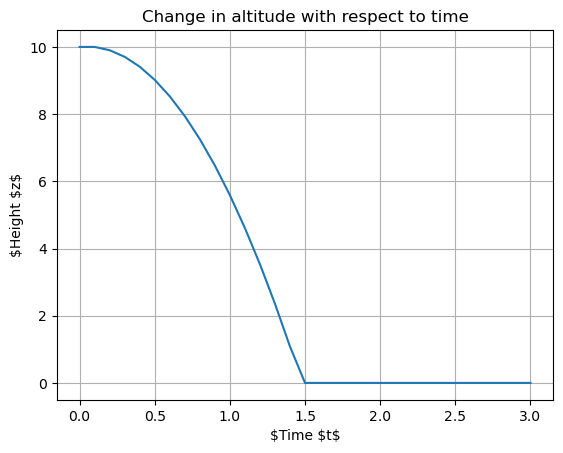

In [183]:
fig, ax = plt.subplots()
ax.plot(time, x_log[:-1,2])
ax.set(title="Change in altitude with respect to time", xlabel="$Time $t$", ylabel="$Height $z$")
ax.grid()


# axes().set_ylabel("Time z")

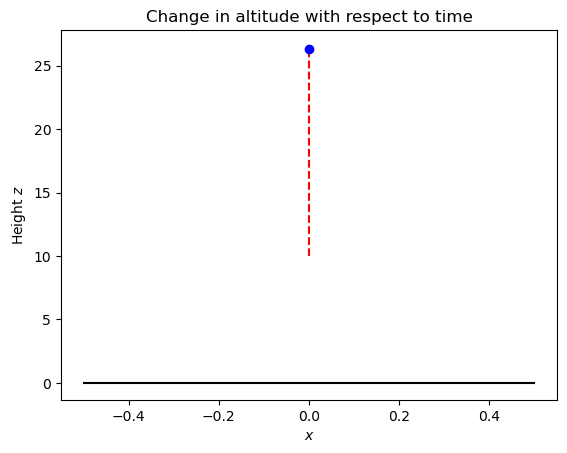

In [152]:
import matplotlib.pyplot as plt
from matplotlib import animation
from JSAnimation import IPython_display    
from IPython.display import HTML
    


fig, ax = plt.subplots()

def animate(t):
    ax.clear()
    
    # Path
    ax.plot(x_log[:,0], x_log[:,2], 'r--')
    
    # Initial conditions
    ax.plot(x_log[t,0], x_log[t,2], 'bo')
    
    # Plot floor
    ax.plot([-0.5,0.5], [0,0], 'k-')
    
    ax.set(title="Change in altitude with respect to time", xlabel="$x$", ylabel="Height $z$")

anim = animation.FuncAnimation(fig, animate, frames=len(time), interval=60)

HTML(anim.to_jshtml())